In [1]:
import time
import copy
import numpy as np
import torch
import tqdm as tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    torch.set_default_device('cuda')
print(device)

def grab(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x

cuda


# Define energy function and its gradient

Here we define the lattice action given as:

\begin{align}
    S_{\text{Lat}} = \sum_x \left[- 2 \sum_{\mu}\phi_x \phi_{x + \mu} \right]  + (2d +  m^2) \phi_x^2 +  \lambda  \phi_x^4, 
\end{align}

where $m^2$ is the particle mass and $\lambda$ is the quartic interaction parameter. The direction $\mu$ says which of the lattice directions (this is written for arbitary number of spacetime directions with lattice spacing $a=1$) to sum over. In what's below we'll just assume a 2D (1+1) lattice. That function is implemented in `action`.

The force, 
$$
F = - \tfrac{\delta S}{\delta \phi(x)},
$$
necessary e.g. for HMC (as it will be used below) is given as:


$$ F(x) = -2 \left(m^2 + 2d \right) \phi(x) - 4 \lambda \phi(x)^3 + 2 \sum_{\hat \mu} \left( \phi(x + \hat{\mu}) + \phi(x - \hat{\mu}) \right). $$


When a linear term is added, representing potentially a external magnetic field $h$, then the action takes the form:

\begin{align}
    S_{\text{Lat}} = \sum_x \left[- 2 \sum_{\mu}\phi_x \phi_{x + \mu} \right]  + (2d +  m^2) \phi_x^2 +  \lambda  \phi_x^4 - h\phi_x.
\end{align}

It naturally follows the force admits the expression:
$$
F(x) = -2 \left(m^2 + 2d \right) \phi(x) - 4 \lambda \phi(x)^3 + 2 \sum_{\hat \mu} \left( \phi(x + \hat{\mu}) + \phi(x - \hat{\mu})\right) - h.
$$

Later on, we also would like to play on a parameter acting tuning the quadratic term of the action. Without magnetic field, one introduces the hamiltonian:

\begin{align}
    S_{\text{Lat}} = \sum_x \left[- 2 \sum_{\mu}\phi_x \phi_{x + \mu} \right]  + (2d +  m^2) \phi_x^2 +  \lambda  \phi_x^4 - k \phi_x^2, 
\end{align}
with the associated force:
\begin{equation}
    F(x) = - \tfrac{\delta S}{\delta \phi(x)} = -2 \left(m^2 + 2d \right) \phi(x) - 4 \lambda \phi(x)^3 + 2 \sum_{\hat \mu} \left( \phi(x + \hat{\mu}) + \phi(x - \hat{\mu}) \right) + 2k\phi(x).
\end{equation}

In [4]:
def action(phi: torch.Tensor, M2: float, lam: float, h:float = 0, k: float = 0):
    """
    Args:
        phi: float. Value of the scalar field at the considered node.
        M2: float. Supposed to represent the mass term
        lam: float. Coefficient of the quartic term.
        h: float. External magnetic field.
        k: float. Coefficient of the supplementary quadratic term.
    Returns:
        The action of the system
    """
    # spatial dimensions, other than batch size
    dims = list(range(1, len(phi.shape)))

    action_density = M2 * phi**2 + lam * phi**4 - h*phi - k * phi**2
    rolled_phi_sum = torch.zeros_like(phi)
    # Assume periodic boundary conditions
    for dim in dims:
        rolled_phi_sum += torch.roll(phi, -1, dim)
        rolled_phi_sum += torch.roll(phi, 1, dim)

    action_density.add_(2 * len(dims) * phi**2)
    action_density.sub_(phi * rolled_phi_sum)

    return torch.sum(action_density, dim=dims)


def force(phi: torch.Tensor, M2: float, lam: float, h: float = 0, k: float = 0):
    """
    Args:
        phi: float. Value of the scalar field at the considered node.
        M2: float. Supposed to represent the mass term
        lam: float. Coefficient of the quartic term.
        h: float. External magnetic field.
        k: float. Coefficient of the supplementary quadratic term.
    Returns:
        The Force of the system
    """
    
    dims = list(range(1, len(phi.shape)))
    force = -2 * (M2 + 4) * phi - 4 * lam * phi**3 + h + 2 * k * phi
    
    rolled_sum = torch.zeros_like(phi)
    # computes phi_x+mu + phi_x-mu
    for dim in dims:
        rolled_sum += torch.roll(phi, -1, dim)
        rolled_sum += torch.roll(phi, 1, dim)
    
    force.add_(2 * rolled_sum)

    return force

In [5]:
import time

In [6]:
## run this twice if using mps to see real time

torch.manual_seed(10)

d = 1 #Not the same quantity than in the action
L = 32
lattice_shape = [L for _ in range(d)]

M2 = -4.0
lam = 4.70
h = 0
k = 1

bs = 10000
phi= 0.2 * torch.randn(bs, *lattice_shape)

tic = time.perf_counter()
F = force(phi, M2, lam, h, k)
toc = time.perf_counter()     
print("second force took:", toc - tic, " seconds")

second force took: 1.2048337822780013  seconds


# Simple HMC algorithm

Below is a simple HMC algorithm that refreshes a momentum `pi` to leapfrog integrate a fictitious hamiltonian dynamics associated with the action defined above. It does it for a batch of samples.

Then following that is an HMC func which calls this `chain_length` amount of times.

`leap` method codes the following steps. One notes $\dot p = -\frac{\partial S}{\partial \phi}$.
First, initialize $\pi_0$ with $\pi_{1/2} = \pi_0 + \frac{1}{2}\epsilon \dot p_0$.
Then, repeat $\text{n}_{\text{steps}} - 1$ times; from $k = 0$ to $k = \text{n}_{\text{steps}} - 2$:
\begin{align}
\phi_{k + 1} = \phi_k + \epsilon \pi_{k + 1/2} \\
\dot{p}_{k+1} = F(\phi_{k+1}) \\
\pi_{k + 3/2} = \pi_{k + 1/2} + \epsilon \dot{p}_{k+1}
\end{align}
Eventually, compute the final iteration $k = \text{n}_{\text{steps}} - 1$:
\begin{align}
\phi_{\text{n}_{\text{steps}}} = \phi_{\text{n}_{\text{steps}} - 1} + \epsilon \pi_{\text{n}_{\text{steps}} - 1/2}\\
\dot{p}_{\text{n}_{\text{steps}}} = F(\phi_{\text{n}_{\text{steps}}})\\
\pi_{\text{n}_{\text{steps}}} = \pi_{\text{n}_{\text{steps} - 1/2}} + \frac{1}{2}\epsilon \dot{p}_{\text{n}_{\text{steps}}}.
\end{align}

Note that when running hmc, $\pi_0$ is sampled from $N(0, \text{Id})$.

The scheme directly stems from the Hamilton equations:
\begin{align}
\dot \phi = \frac{\partial H}{\partial \pi},\\
\dot \pi = - \frac{\partial H}{\partial \phi},
\end{align}
and it turns out that $\frac{\partial H}{\partial \pi} = \pi$. The hamiltonian is computed here as $H = \frac{1}{2}\pi^2 + S_\text{lat}$

In [7]:
def leap(phi, pi, force_fn, eps, n_steps):
    """Perform leapfrog steps."""
    pi += 0.5 * eps * force_fn(phi)
    for i in range(n_steps - 1):
        phi += eps * pi
        pi += eps * force_fn(phi)
    phi += eps * pi
    pi += 0.5 * eps * force_fn(phi)
    return phi, pi

def hmc(phi, action_fn, force_fn, eps=0.1, n_steps=10):
    """
    Runs n_step leapfrog steps of HMC, with step size eps,
    on a batch of phi lattices, of shape [bs, L, L].
    Accepts or rejects this update
    Args:
        phi: float. Value of the field at this node.
        action_fn: Callable. Function to compute the action.
        force_fn: Callable. Function to cmpute the force.
        eps: float. Step size.
        n_steps: int. Number of steps to perform in the leaps frog scheme.
    Returns:
        Perform a sampling with Hamiltonian Monte Carlo methods.
    """
    dims = list(range(1, len(phi.shape)))
    S = action_fn(phi)

    new_phi = torch.clone(phi)
    pi = torch.randn(phi.shape)
    hamiltonian = 0.5 * torch.sum(pi**2, dims) + S

    new_phi, pi = leap(new_phi, pi, force_fn, eps, n_steps)

    new_S = action_fn(new_phi)
    d_hamiltonian = 0.5 * torch.sum(pi**2, dims) + new_S - hamiltonian

    #Metropolis steps
    accept = torch.rand(len(d_hamiltonian)) < torch.exp(-d_hamiltonian)
    a = accept.view((-1,) + (1,)*d).repeat(1,*phi.shape[1:])

    return a * new_phi + ~a * phi, accept

In [8]:
def run_hmc(
        chain_length: int,
        phi: torch.Tensor,
        hmc_fn,
        verbose: bool=True):
    if verbose:
        accept_rate = 0
        trange = tqdm.trange(chain_length)
        for i in trange:
            phi, accept = hmc_fn(phi)
            accept_rate += np.mean(grab(accept))
            trange.set_postfix(acc=str(np.round(accept_rate / (i+1), 2)))
        print(f"\nacceptance rate: {accept_rate / chain_length}")
    else:
        for i in range(chain_length):
            phi, _ = hmc_fn(phi)

    return phi

## Run the HMC

- Running with parameters $m^2 = -4$, $\lambda = 4.70$, $h = 0$ at lattice size $L=32$ for example would be right near the phase transition to the double well.

- Running with parameters $m^2 = -4.4$, $\lambda = 4.70$, $h = 0$ at lattice size $L=32$ for example would be into the double well potential (magnetized) phase.

- Running with parameters $m^2 = -4.4$, $\lambda = 4.70$, $h = 10$ at lattice size $L=32$ for example would be into the double well potential (magnetized) phase within a magnetic field.

In [22]:
d = 2
L = 32
lattice_shape = [L for _ in range(d)]

M2 = -4.
lam = 4.572
h = 0
k2 = 0

bs = 70000
phi= 0.2 * torch.randn(bs, *lattice_shape)

eps = 0.07
n_steps = 10

action_fn = lambda phi: action(phi, M2, lam, h, k2)
force_fn  = lambda phi: force(phi, M2, lam, h, k2)
hmc_fn    = lambda phi: hmc(phi=phi, action_fn=action_fn, force_fn=force_fn, 
                            eps=eps, n_steps = n_steps)

## phi_ts is the mcmc chain of phis, initialized below of batch size `bs`
phi_ts = run_hmc(
    chain_length=2000,
    phi=0.1 * torch.randn(bs, *lattice_shape),
    hmc_fn=hmc_fn)
print(phi_ts.shape)

100%|██████████| 2000/2000 [02:33<00:00, 13.05it/s, acc=0.77]


acceptance rate: 0.7656492571428561
torch.Size([70000, 32, 32])


10000

#### visual some lattices

<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1524878/1273240538.py:32: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle(r"$L=$" + str(L) + f" $\phi$ configurations with $m^2 = {m2}$, "
/tmp/ipykernel_1524878/1273240538.py:33: SyntaxWarning: invalid escape sequence '\l'
  + f" $\lambda = {lam}$, " + f" $h = {h}$ " + f"k = {k}", fontsize = 18 )
/tmp/ipykernel_1524878/1273240538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


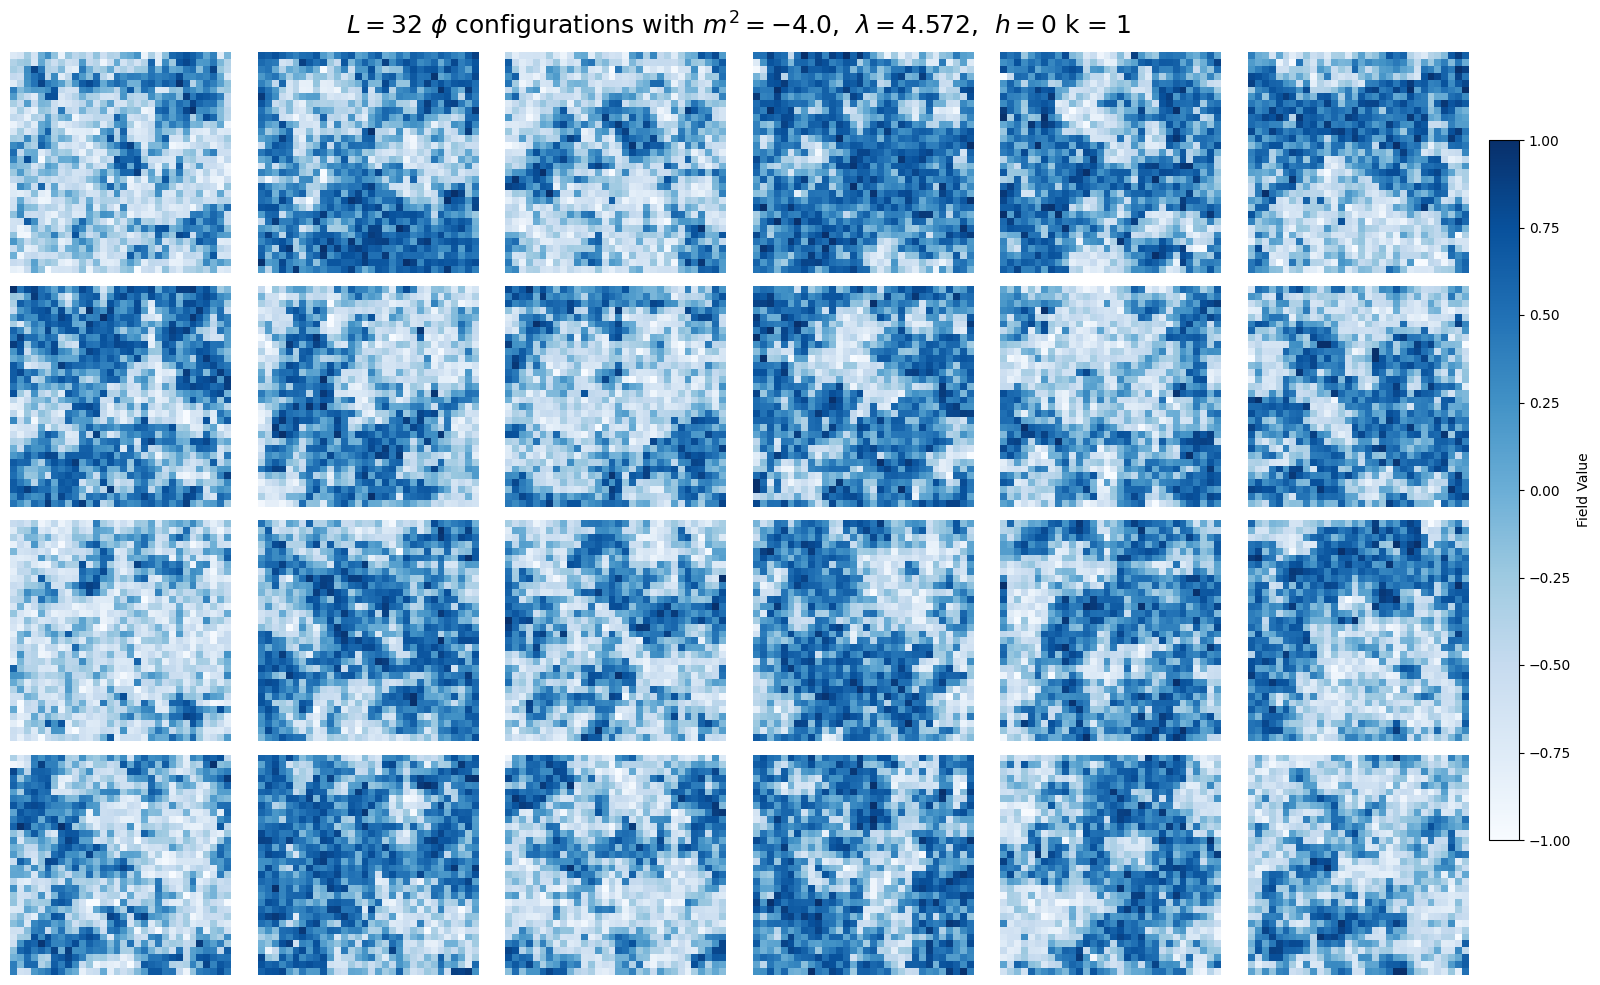

In [12]:
import matplotlib.pyplot as plt

def plot_samples(phi, m2, lam, L, n_rows=4, n_cols=6):
    r"""
    visualize a subset of the lattices in a grid.

    Parameters:
    - phi:    (torch.tensor), tensor of shape [bs, L, L] representing the batch of lattices.
    - n_rows: (int), number of rows in the subplot grid.
    - n_cols: (int), number of columns in the subplot grid.
    """
    bs, L, _ = phi.shape
    n_plots = min(n_rows * n_cols, bs)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    
    ## select some random phi configs
    indices = np.random.choice(bs, n_plots, replace=False)  

    for i, idx in enumerate(indices):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        im = ax.imshow(phi[idx].cpu().numpy(), cmap='Blues', origin='lower', vmin = -1, vmax = 1)
        ax.axis('off') 

    # Add a colorbar
    cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Field Value')
    # cbar.set_clim(-1., 1.)
    fig.suptitle(r"$L=$" + str(L) + f" $\phi$ configurations with $m^2 = {m2}$, "
                 + f" $\lambda = {lam}$, " + f" $h = {h}$ " + f"k = {k}", fontsize = 18 )

    plt.tight_layout()
    plt.show()

plot_samples(phi_ts, M2, lam, L)

In [14]:
### Compute average magnetization
mags_std = (torch.mean(phi_ts, dim=(1,2))) ## magnetizations

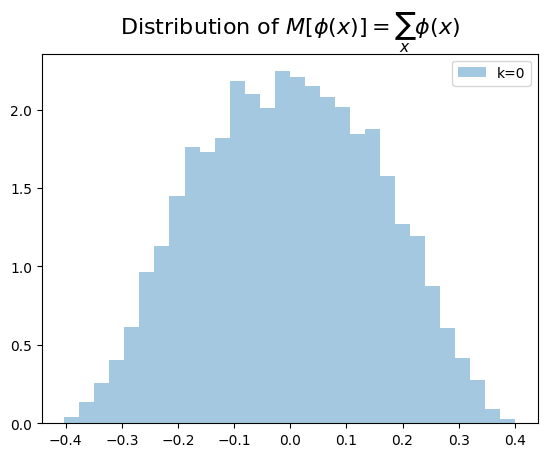

In [18]:
plt.hist(grab(mags_std), bins = 30, alpha = 0.4, density=True, label = "k=0")
# plt.hist(grab(mags_k_minus1), bins = 30, alpha = 0.4, label = "$-k^2=-1$", density=True)
# plt.hist(grab(mags_k_minus05), bins = 30, alpha = 0.4, label = "$-k^2=-0.05$", density=True)
plt.title(r"Distribution of $M[\phi(x)] = \sum_x \phi(x)$", fontsize = 16)
plt.legend()
plt.show()

In [23]:
np.save("./data/2D_phi4_L" + str(L) + "_m2" + str(M2) + "_lam" + str(lam) + ".npy", grab(phi_ts))

In [27]:
np.save("./data/2D_phi4_L" + str(L) + "_m2" + str(M2) + "_lam" + str(lam) + "k2" + "-1" + ".npy", grab(phi_ts))